# <p align="center">DDPO lora VS base 生图效果对比

In [2]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
dtype = torch.float16 if device in ["cuda", "mps"] else torch.float32

print("device:", device, "dtype:", dtype)


/Users/shuoxu/Applications/anaconda3/envs/ddpo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/shuoxu/Applications/anaconda3/envs/ddpo/lib/python3.10/site-packages/accelerate/utils/torch_xla.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


device: mps dtype: torch.float16


In [3]:
base_model_id = "runwayml/stable-diffusion-v1-5"  # config.pretrained.model
ckpt_dir = "../logs/2026.01.05_07.54.36/checkpoints/checkpoint_3"
lora_weight_name = "pytorch_lora_weights.bin"    


加载 base pipeline 不带LoRA，生成一张图

/Users/shuoxu/Applications/anaconda3/envs/ddpo/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 30/30 [00:1

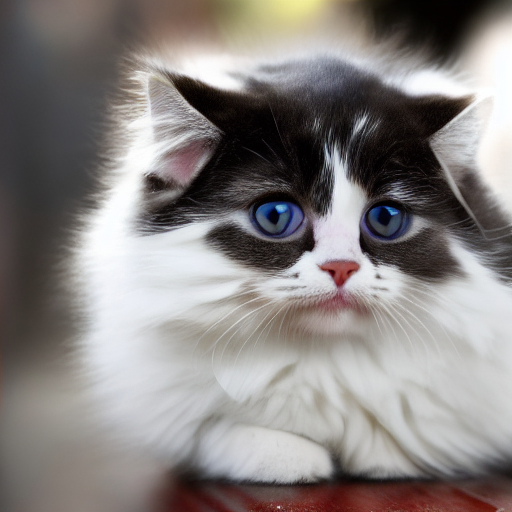

In [4]:
pipe_base = StableDiffusionPipeline.from_pretrained(
    base_model_id,
    torch_dtype=dtype,
    safety_checker=None,  # 可选
)
pipe_base.scheduler = DDIMScheduler.from_config(pipe_base.scheduler.config)  # 可选：用 DDIM
pipe_base.scheduler.eta = 1.0
pipe_base = pipe_base.to(device)

prompt = "a photo of a cute cat, high quality"
num_steps = 30
guidance = 7.5
seed = 12345

g = torch.Generator(device=device).manual_seed(seed)
img_base = pipe_base(prompt, num_inference_steps=num_steps, guidance_scale=guidance, generator=g).images[0]
img_base


加载同一个 base pipeline + 注入 LoRA，再生成一张图

/Users/shuoxu/Applications/anaconda3/envs/ddpo/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/Users/shuoxu/Applications/a

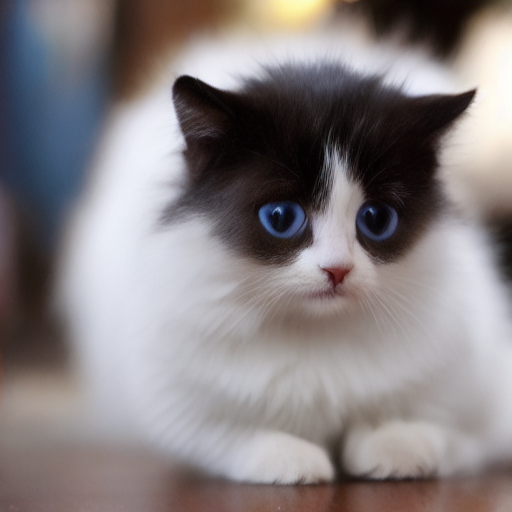

In [5]:
pipe_lora = StableDiffusionPipeline.from_pretrained(
    base_model_id,
    torch_dtype=dtype,
    safety_checker=None,
)
pipe_lora.scheduler = DDIMScheduler.from_config(pipe_lora.scheduler.config)
pipe_lora.scheduler.eta = 1.0
pipe_lora = pipe_lora.to(device)

# 关键：加载 checkpoint_3 里的 lora 权重
pipe_lora.load_lora_weights(ckpt_dir, weight_name=lora_weight_name)

# 可选：LoRA 强度（1.0 是默认）
# pipe_lora.set_adapters(["default"], adapter_weights=[1.0])  # 某些版本需要/支持

g = torch.Generator(device=device).manual_seed(seed)
img_lora = pipe_lora(prompt, num_inference_steps=num_steps, guidance_scale=guidance, generator=g).images[0]
img_lora


并排对比显示

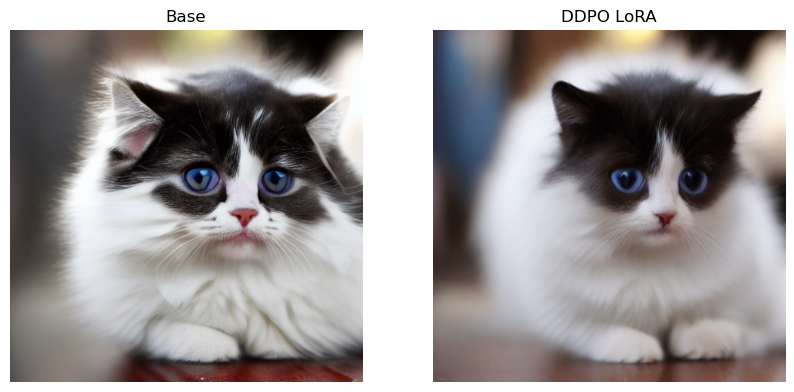

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_base); axes[0].set_title("Base"); axes[0].axis("off")
axes[1].imshow(img_lora); axes[1].set_title("DDPO LoRA"); axes[1].axis("off")
plt.show()


reward打分对比

In [7]:
from pathlib import Path
import sys


REPO_ROOT = Path.cwd().resolve().parent
print("REPO_ROOT =", REPO_ROOT)

# 确保可以 import ddpo_pytorch
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


REPO_ROOT = /Users/shuoxu/Desktop/图灵学术/第3阶段：复现工作/2.DDPO复现工作/DDPO源代码/ddpo-pytorch


In [8]:
import ddpo_pytorch.rewards as rewards

# TODO: 这里填你训练用的 reward_fn 名字（和 config.reward_fn 一致）
# 常见例子： "jpeg_incompressibility", "jpeg_compressibility", "aesthetic_score" ...
REWARD_FN_NAME = "jpeg_incompressibility"

reward_factory = getattr(rewards, REWARD_FN_NAME)
reward_fn = reward_factory()  # 训练里就是 rewards.<name>() 得到可调用的 reward_fn

print("Loaded reward_fn =", REWARD_FN_NAME, "->", reward_fn)


Loaded reward_fn = jpeg_incompressibility -> <function jpeg_incompressibility.<locals>._fn at 0x37fbad1b0>


In [9]:
import torch
import numpy as np

def pil_to_nchw01(pil_img):
    """
    PIL.Image (H,W,3, uint8) -> torch.Tensor (1,3,H,W) float32 in [0,1]
    """
    arr = np.array(pil_img).astype(np.float32) / 255.0          # (H,W,3)
    t = torch.from_numpy(arr).permute(2, 0, 1).unsqueeze(0)     # (1,3,H,W)
    return t

# 1) PIL -> tensor batch
img_base_t = pil_to_nchw01(img_base)
img_lora_t = pil_to_nchw01(img_lora)

images_t = torch.cat([img_base_t, img_lora_t], dim=0)  # (2,3,H,W)

# 2) reward_fn 的 prompts / metadata 仍然照常传
prompts = [prompt, prompt]
metadata = [{}, {}]

# 3) 打分
scores, info = reward_fn(images_t, prompts, metadata)

# 4) 转成 float 打印
scores_list = torch.as_tensor(scores).detach().cpu().flatten().tolist()

print(f"[Reward = {REWARD_FN_NAME}]")
print("Base score:", scores_list[0])
print("LoRA score:", scores_list[1])
print("Delta (LoRA - Base):", scores_list[1] - scores_list[0])

if isinstance(info, dict) and len(info) > 0:
    print("\n[info keys]", list(info.keys()))



[Reward = jpeg_incompressibility]
Base score: 74.006
LoRA score: 55.279
Delta (LoRA - Base): -18.726999999999997
